# BERT - Classify Spam or Not Spam

In this second notebook of BERT, we want to use BERT on a Classification Problem. 

> The first notebook, which was an introduction to BERT, can be found at [this page](https://www.kaggle.com/code/alishohadaee/dl-introduction-to-bert). 

In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

2024-05-06 10:26:50.133016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 10:26:50.133112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 10:26:50.387140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Data and Preprocessing

In [2]:
df = pd.read_csv("/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv")
df.head(5)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


According to the dataset, 0 indicates `not spam` and 1 indicates `spam`. 

In [3]:
df['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

In [4]:
500/2500

0.2

20% spam, 80% Not Spam. This is a considerable imbalance between the classes. We take care of it by downsampling. In downsampling, we choose the same amount of the data from the class with higher frequency to the class with lower frequency. 

In [5]:
df_spam = df[df['label'] == 1]
df_spam.shape

(500, 2)

In [6]:
df_nspam = df[df['label']==0]
df_nspam.shape

(2500, 2)

In [7]:
df_nspam_downsampled = df_nspam.sample(df_spam.shape[0])
df_nspam_downsampled.shape

(500, 2)

In [8]:
df_balanced = pd.concat([df_nspam_downsampled, df_spam])
df_balanced.shape

(1000, 2)

In [9]:
df_balanced['label'].value_counts()

label
0    500
1    500
Name: count, dtype: int64

# 2. Splitting dataset

In [10]:
from sklearn.model_selection import train_test_split

X = df_balanced['email']
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [11]:
X_train.head(4)

2765     don t wait refinance now take advantage of th...
1842    url URL date NUMBER NUMBER NUMBER NUMBER NUMBE...
712      and say hello to the cool oooo this is going ...
996      on tue NUMBER sep NUMBER NUMBER NUMBER NUMBER...
Name: email, dtype: object

# 3. BERT Initialization
We do the following as we described it in [previous notebook](https://www.kaggle.com/code/alishohadaee/dl-introduction-to-bert). 

In [12]:
bert_preprocess = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
bert_encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/4")

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/en-uncased-l-12-h-768-a-12/4' to your Kaggle notebook...


As described before, the `pooled_output` value is used for classification problem. That's why we return it in the next defined function. 

In [13]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

# Example
get_sentence_embeding([
    "Click and get thousands of money", 
    "Hey Ali Shohadaee, are you comming tommorow for festival?"]
    )

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.7468495 , -0.39978012, -0.7962678 , ..., -0.6996817 ,
        -0.61443937,  0.7623512 ],
       [-0.81543624, -0.36400348, -0.8609254 , ..., -0.8127121 ,
        -0.6290068 ,  0.889372  ]], dtype=float32)>

#### Checking similarites 
In the next cell we define some random words, and then we calculate their similarities.

In [14]:
words = get_sentence_embeding([
    "MIlk", 
    "Cucumbers",
    "tree",
    "University of Bologna",
    "Ali Shohadaee",
    "Deep Learning",
    "Artificial Intelligence",
    "University of Mazandaran",
    "Machine Learning"
    ])

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([words[3]],[words[7]])

array([[0.97753453]], dtype=float32)

Values near to 1 means they are similar and near to 0 means they are very different. As the output suggests, the two universities are very similar. 

# 4. BERT Model Building 
In deep learning, particularly with frameworks like TensorFlow and Keras, model building can generally be categorized into two styles: **Sequential** and **Functional**. These styles provide different methods for constructing neural network architectures, offering flexibility and control suited to specific needs.

### Sequential Model Building

The **Sequential** model is the simplest way to assemble layers in a neural network. It is designed for creating models with a single input and output, where layers are stacked sequentially, each feeding directly into the next.

- **Advantages**:
  - **Simplicity**: The sequential model is very straightforward to use and understand. It is perfect for beginners or when working with standard layer architectures that involve straightforward data flows.
  - **Ease of use**: With the sequential model, you can easily stack layers using a list or by repeatedly calling the `add()` method on the model.

- **Example** (Using TensorFlow/Keras):
  ```python
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Flatten

  model = Sequential([
      Flatten(input_shape=(28, 28)),  # Converts input shape of 28x28 into a 1D array
      Dense(128, activation='relu'),
      Dense(10, activation='softmax')
  ])
  ```

### Functional Model Building

The **Functional** model offers more flexibility and is used for creating models that might have non-linear topology, shared layers, and multiple inputs or outputs. This approach defines a graph of layers, which means you can connect any layer to any other layer instead of just the next one in a sequence.

- **Advantages**:
  - **Flexibility**: The functional API can handle models with multiple inputs and outputs, which is difficult with the sequential model.
  - **Complex Architectures**: It supports complex architectures like multi-output models, directed acyclic graphs, or models with shared layers.

- **Example** (Using TensorFlow/Keras):
  ```python
  from tensorflow.keras.layers import Input, Dense, Concatenate
  from tensorflow.keras.models import Model

  input_a = Input(shape=(32,))
  input_b = Input(shape=(32,))

  dense_1 = Dense(64, activation='relu')(input_a)
  dense_2 = Dense(64, activation='relu')(input_b)
  concat = Concatenate()([dense_1, dense_2])
  output = Dense(1, activation='sigmoid')(concat)

  model = Model(inputs=[input_a, input_b], outputs=output)
  ```

### Choosing Between Sequential and Functional

- **Use Sequential** when:
  - Your model has a single input and output.
  - Your model is a linear stack of layers.


- **Use Functional** when:
  - Your model has multiple inputs or outputs.
  - Any of your layers has multiple inputs or outputs.
  - You need to do layer sharing.
  - You want to create complex topologies like multi-branch models or residual connections.

The choice between sequential and functional APIs ultimately depends on the complexity of the model you're trying to build and the specific requirements of your project. For many standard tasks, the sequential model is sufficient and easier to manage, while the functional API is excellent for more sophisticated, custom architectures.

> Due to inconsistency that currently, 6th of May, exists between Keras V3.x and Tensorflow Hub, we install an older version of Tensorflow which has keras version 2.

In [16]:
!pip install tf_keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [17]:
import tf_keras as tfk

In [18]:
# Bert layers
text_input = tfk.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tfk.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tfk.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tfk.Model(inputs=[text_input], outputs = [l])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [20]:
METRICS = [
      tfk.metrics.BinaryAccuracy(name='accuracy'),
      tfk.metrics.Precision(name='precision'),
      tfk.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

# 5. Training the Model

Before that, the data needs to be converted. If you remember and noticed, the input layer of the network is configured for `dtype=tf.string`, so it expects the input data to be string. Hence, we change the type of `Xtrain` in the following:

In [21]:
import numpy as np

In [22]:
# Check data types
print("X_train data type:", X_train.dtype)
print("y_train data type:", y_train.dtype)

# Convert y_train to float32 if necessary
X_train = np.array(X_train, dtype=str)
y_train = y_train.astype('float32')

# Verify the conversion
print("y_train new data type:", y_train.dtype)
print("X_train new data type:", X_train.dtype)

# Changing the shape of y_train - Not Mandatory
print("Shape of y_train before:", y_train.shape)
y_train = np.expand_dims(y_train, axis=-1)  # Reshape to (num_samples, 1) if necessary
print("Shape of y_train after:", y_train.shape)

X_train data type: object
y_train data type: int64
y_train new data type: float32
X_train new data type: <U200408
Shape of y_train before: (750,)
Shape of y_train after: (750, 1)


In [23]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
 1/24 [>.............................] - ETA: 13:13 - loss: 0.7232 - accuracy: 0.4062 - precision: 0.4444 - recall: 0.7500

I0000 00:00:1714991311.315749      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 43s 373ms/step - loss: 0.6864 - accuracy: 0.5507 - precision: 0.5505 - recall: 0.5520
Epoch 2/10
24/24 [==============================] - 9s 375ms/step - loss: 0.6545 - accuracy: 0.6373 - precision: 0.6467 - recall: 0.6053
Epoch 3/10
24/24 [==============================] - 9s 371ms/step - loss: 0.6332 - accuracy: 0.6320 - precision: 0.6486 - recall: 0.5760
Epoch 4/10
24/24 [==============================] - 9s 376ms/step - loss: 0.6149 - accuracy: 0.6720 - precision: 0.6577 - recall: 0.7173
Epoch 5/10
24/24 [==============================] - 9s 378ms/step - loss: 0.6013 - accuracy: 0.7080 - precision: 0.7364 - recall: 0.6480
Epoch 6/10
24/24 [==============================] - 9s 383ms/step - loss: 0.5844 - accuracy: 0.7213 - precision: 0.7173 - recall: 0.7307
Epoch 7/10
24/24 [==============================] - 9s 379ms/step - loss: 0.5629 - accuracy: 0.7373 - precision: 0.7587 - recall: 0.6960
Epoch 8/10
24/24 [==============================] -

In [24]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 4s 335ms/step - loss: 0.5121 - accuracy: 0.7960 - precision: 0.7681 - recall: 0.8480


[0.512091875076294, 0.7960000038146973, 0.7681159377098083, 0.8479999899864197]

In [25]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

8/8 [==============================] - 4s 334ms/step


Next cell puts threshold for this classification:

In [26]:
def define_predict_class(y_pred):
    return np.where(y_pred > 0.5, 1, 0)

y_predicted = define_predict_class(y_predicted)
y_predicted

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1])

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[ 93,  32],
       [ 19, 106]])

Text(50.722222222222214, 0.5, 'Truth')

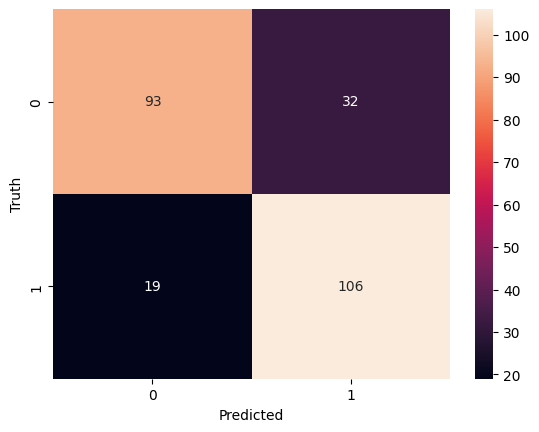

In [28]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [29]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       125
           1       0.77      0.85      0.81       125

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250



Not a bad accuracy. 

# 6. Inferencing 

In [30]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
print("\nPredicted probability:", model.predict(reviews), "\n\nClass:", define_predict_class(model.predict(reviews)))

1/1 [==============================] - 0s 51ms/step

Predicted probability: [[0.5393355 ]
 [0.4945383 ]
 [0.49699938]
 [0.3017626 ]
 [0.31330362]] 

Class: [[1]
 [0]
 [0]
 [0]
 [0]]
